# Experiment 1 - Split Connectivity [WIP]

## Objective
[TODO]

## Model
Every neuron in the model is a leaky integrate-and-fire neuron with an exponetial post-synaptic curve.

### Inputs
Each image is sourced from a single alphabet of the Omniglot dataset, with no overlapping characters. For the sake of this experiment, we treat each character as a sole member of its own class. This way $N_{class} = 2$ means our random copies of either one of 2 image vectors. To add a small amount of variance to the samples, a small amount of uniform noise $\epsilon_{noise} \in \mathcal{U(0,25)}$ (milliseconds) is added to each input spike.

Inputs are modelled as $N_{PN} = d_{input}$ spiking Projection Neurons (PN), where $d_{input}$ is the dimensionality of the flattened image vectors. Each image is encoded as a simultaneous spiking of all active (pixel value = 1) neurons, with some jitter, within a 50ms window.

### Layers
For $N_{class} = 2$, half the iKCs are connected to the neurons active in class A, and the rest to those active in class B. For $N_{class} > 2$, connectivity is made with $p=0.15$

iKCs feed into eKCs with all to all connectivity and an additive STDP mechanism. The number of neurons in each layer are $N_{iKC}$ and $N_{eKC}$ respectively, where:
\begin{align}
N_{iKC} &= 2\cdot d_{input}\\
N_{eKC} &= \lceil \log_2N_{class} \rceil & (1)
\end{align}

The number of eKC neurons is thus approximately the minimal amount of neurons needed to represent every class by co-occurrence of instantaneous$^1$ spikes.

## Methodology and Evaluation
Inputs are sampled randomly from $N_{class}$ separate classes and shown to the model at 50ms intervals. $N_{sample}$ samples are shown to the model for the duration of the simulation, starting at the first 50ms onwards. iKC and eKC activity as a response to input spikes is recorded within these time frames. Every simulation step we calculate the average inter and intra class distances, $D_{inter}$ and $D_{intra}$, with a cosine distance metric, modified for numeric stability (in the case of no spiking neurons):

$$
\hat{D}_C(a,b) = D_C(a + \epsilon_{d}, b + \epsilon_{d}) 
$$

--

$^1$ Within a 50ms time window



In [ ]:
# Add my library
import sys
import os

sys.path.append(os.getcwd() + "/lib")

In [12]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import pynn_genn as sim
from pyNN.random import NumpyRNG

import lib.simulation as S
import lib.metrics as metrics
from lib.model import build_PN, build_population
from lib.data import Alphabet
from lib.embedding import generate_spike_arrays

Flattened: (2, 729)


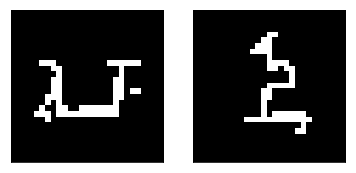

In [32]:
# Get first two characters of "Alphabet of the Magi" alphabet
data_dir = "omniglot/python/images_background"
dataset = Alphabet(data_dir, 0)
samples = dataset[:2,0]

# Downsample
samples = samples[:,::4,::4]

# Binarize
samples[samples >= 0.5] = 1.0
samples[samples < 0.5] = 0.0 

# Invert (active is drawing not background)
samples = 1 - samples

# Preview
fig, axes = plt.subplots(1,2)
for ax,img in zip(axes, samples):
    ax.imshow(img, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

# Flatten
samples = samples.reshape(2, -1)
print("Flattened:", samples.shape)


In [33]:
def setup(images, classes, params, seed=None, silent=True):
    def split_PN_iKC_model(inputs, **params):

        # Populations
        p_params = params['population']
        pop_PN = build_PN(inputs)
        n_iKC = len(pop_PN) * 10
        pop_iKC = build_population(n_iKC, params['neuron'], "iKC")
        pop_eKC = build_population(p_params['n_eKC'], params['neuron'], 'eKC')

        # Connections
        ixs = np.arange(images.shape[1])
        active_A, active_B = np.round(ixs * images[0]).astype('int'), np.round(ixs * images[1]).astype('int')

        PN_A, PN_B = pop_PN[active_A], pop_PN[active_B]

        iKC_A, iKC_B = pop_iKC[:int(n_iKC/2)], pop_iKC[int(n_iKC/2):]

        # Split connections
        PN_iKC_A = sim.Projection(PN_A, iKC_A,
                                  sim.AllToAllConnector(),
                                  sim.StaticSynapse(weight=0.25, delay=2.0),
                                  receptor_type="excitatory",
                                  label="PN_iKC_A")

        PN_iKC_B = sim.Projection(PN_B, iKC_B,
                                  sim.AllToAllConnector(),
                                  sim.StaticSynapse(weight=0.25, delay=2.0),
                                  receptor_type="excitatory",
                                  label="PN_iKC_B")

        # iKCs to eKCs
        iKC_eKC = sim.Projection(pop_iKC, pop_eKC,
                                sim.AllToAllConnector(),
                                sim.STDPMechanism(**params['plasticity']),
                                receptor_type='excitatory',
                                label="iKC_eKC")

        return {
            "model": sim.Assembly(pop_PN, pop_iKC, pop_eKC),
            "projections": {
                "PN_iKC_A": PN_iKC_A,
                "PN_iKC_B": PN_iKC_B,
                "iKC_eKC": iKC_eKC
            }
        }


    intervals = S.gen_intervals(params['t_snapshot'], params['n_samples'], params['t_snapshot'])
    input_spikes, labels = generate_spike_arrays(
        images, classes,
        intervals,
        params['t_snapshot'],
        params['snapshot_noise']
    )
    
    MB  = S.setup_experiment(input_spikes, params, split_PN_iKC_model)

    model, projections = MB['model'], MB['projections']
    
    if not silent:
        print("Populations")
        print(" n_PN:", len(model.get_population('PN')))
        print(" n_iKC:", len(model.get_population('iKC')))
        print(" n_eKC:", len(model.get_population('eKC')))
        print()
        print("Projections")
        print(" PN->iKC (A):",projections['PN_iKC_A'].shape)
        print(" PN->iKC (B):",projections['PN_iKC_B'].shape)
        print(" iKC->eKC   :",projections['iKC_eKC'].shape)
    
    return MB, labels, intervals

In [34]:
# Inputs
INPUTS = samples
CLASSES = np.arange(samples.shape[0])

# Constant params
T_SNAPSHOT = 50
DELTA_T = 0.1

D_INPUT = INPUTS.shape[1]
N_CLASS = INPUTS.shape[0]
N_SAMPLES = 20
N_EKC = int(np.ceil(np.log2(N_CLASS)))

PARAMS = S.default_params(DELTA_T, T_SNAPSHOT, D_INPUT, N_SAMPLES, N_EKC)

# Setup experiment
MB, labels, intervals  = setup(INPUTS, CLASSES, PARAMS)

In [35]:
# Run the simulation
results = S.run_experiment(MB, intervals, PARAMS)

Running experiment

[ ########################################################################### ] 100% 

Total Steps: 1100ms


In [36]:
def analysis(res):
    eKC_activity = res['activity']['eKC'][0]
    
    inter = metrics.interclass(eKC_activity, labels, D=metrics.cosine_distance)
    
    return inter.mean()
    

In [37]:
# Analysis across runs
analysis(results)

2.220446049250313e-16

In [8]:
S.cleanup()

Ending Simulation...
